This section of code refers to data drift detection within the dataset. It starts by searching for three different cameras. Ideally, we want three cameras with large amounts of data.

## Data cleaning and manipulation

In [72]:
# cleaning data
import os
import pandas as pd

# viewing images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from datetime import datetime



In [73]:
# This function returns the file path, site and label of each image
# returns a 
def label_images(base_dir):
    image_data = []

    # Traverse the base directory to find all site directories
    for site in os.listdir(base_dir):
        site_path = os.path.join(base_dir, site)
        if os.path.isdir(site_path):
            # Define the subdirectories within each site
            subdirs = ['blocked', 'clear', 'other']

            # Traverse each subdirectory
            for subdir in subdirs:
                subdir_path = os.path.join(site_path, subdir)

                if os.path.exists(subdir_path):
                    # Walk through the subdirectory
                    for root, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                                # Full file path
                                file_path = os.path.join(root, file)

                                # Append the data to the list
                                image_data.append({
                                    'file_path': file_path,
                                    'file': file,
                                    'site': site,
                                    'label': subdir
                                })

    # Create a DataFrame from the collected data
    df = pd.DataFrame(image_data)

    return df

# Executed
base_dir = 'Data/blockagedetection_dataset/images'
df_images = label_images(base_dir)

print(df_images.head(5))

                                           file_path                  file  \
0  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_09_00.jpg   
1  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_14_45.jpg   
2  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_12_30.jpg   
3  Data/blockagedetection_dataset/images/Devon_Ho...  2022_02_14_09_15.jpg   
4  Data/blockagedetection_dataset/images/Devon_Ho...  2022_11_08_07_30.jpg   

                    site    label  
0  Devon_Holbeam_Impound  blocked  
1  Devon_Holbeam_Impound  blocked  
2  Devon_Holbeam_Impound  blocked  
3  Devon_Holbeam_Impound  blocked  
4  Devon_Holbeam_Impound  blocked  


In [74]:
# Filter out the 'other' label
df_filtered = df_images[df_images['label'].isin(['blocked', 'clear'])]

# Group by site and label, then count the images
summary = df_filtered.groupby(['site', 'label']).size().unstack(fill_value=0)

# Determine the minimum count between blocked and clear labels for each site
summary['balanced'] = summary[['blocked', 'clear']].min(axis=1)

In [85]:
# Collect balanced data for each site
balanced_data = []
for site in summary.index:
    min_count = summary.loc[site, 'balanced']
    
    blocked_images = df_filtered[(df_filtered['site'] == site) & (df_filtered['label'] == 'blocked')].sample(min_count)
    clear_images = df_filtered[(df_filtered['site'] == site) & (df_filtered['label'] == 'clear')].sample(min_count)
    
    balanced_data.append(blocked_images)
    balanced_data.append(clear_images)

# Concatenate the balanced data
balanced_df = pd.concat(balanced_data)

# Aggregate the counts for balanced images
balanced_summary = balanced_df.groupby(['site', 'label']).size().unstack(fill_value=0)
balanced_summary['total'] = balanced_summary['blocked'] + balanced_summary['clear']

# Select the top three sites with the highest number of balanced images
top_balanced_sites = balanced_summary.nlargest(7, 'total') # chosen 7 as these each have 1000 images

label                           blocked  clear  total
site                                                 
sites_corshamaqueduct_cam1          733    733   1466
Cornwall_BudeCedarGrove             673    673   1346
Cornwall_Crinnis                    639    639   1278
Devon_BarnstapleConeyGut_Scree      596    596   1192
Cornwall_Mevagissey_PreScree        541    541   1082
sites_sheptonmallet_cam2            538    538   1076
Cornwall_PenzanceCC                 512    512   1024


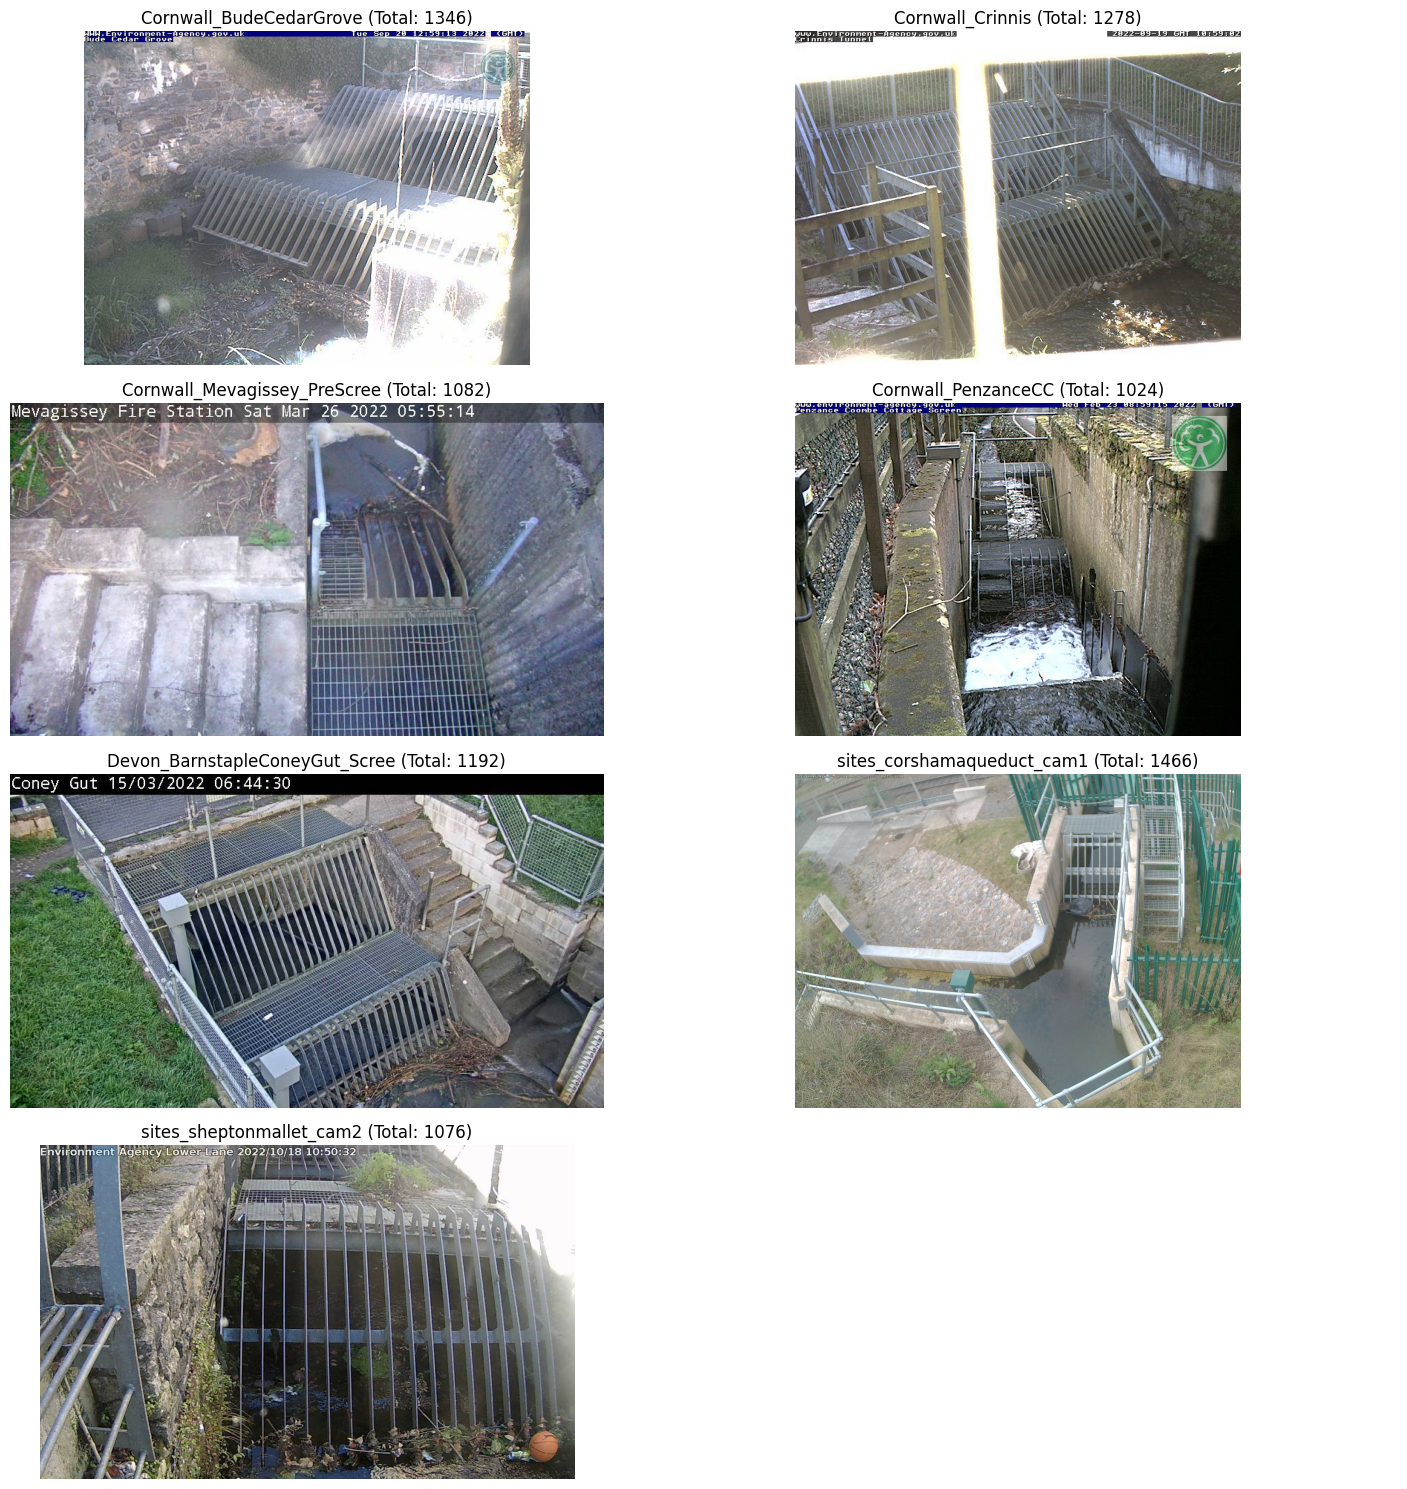

In [86]:
# Select one image per site 
example_images = balanced_df[balanced_df['site'].isin(top_balanced_sites.index)].groupby('site').first().reset_index()

# Get the total count
example_images = example_images.merge(top_balanced_sites['total'], on='site')

# Plot the images in a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(example_images) and i < 7:  # Ensure we only plot 7 images
        img_path = example_images.iloc[i]['file_path']
        img = mpimg.imread(img_path)
        site = example_images.iloc[i]['site']
        total = example_images.iloc[i]['total']
        ax.imshow(img)
        ax.set_title(f"{site} (Total: {total})")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

After viewing these images and noting the different trash screens, I decided to use the sites: sites_corshamaqueduct_cam1, Cornwall_BudeCedarGrove, Devon_BarnstapleConeyGut_Scree. Although Cornwall_Crinnis has 84 more images than Devon_BarnstapleConeyGut_Scree, i have chosen to use exclude this site at is similar to sites_corshamaqueduct_cam1.

## Seasonal data divide.

Now that we have the three sites, I divide each site up into seasons. And merge the data so to have summer, winter, autumn and spring data. 

According to this website, the season dates are defined as follows:

Thus for us in Europe:

Spring is deemed to start at the Vernal Equinox (near 20 March)
Summer at the Summer Solstice (near 21 June)
Autumn at the Autumn Equinox (near 23 September)
Winter at the Winter Solstice (near 22 December).

https://www.rmg.co.uk/stories/topics/when-does-spring-start#:~:text=Spring%20is%20deemed%20to%20start,Solstice%20(near%2022%20December).

In now need to divide the data up by dates:
Spring March 20 - June 20
Summer June 21 - September 22
Autumn September 23 - December 21
Winter December 22 - March 19

In [87]:
# Extract the datetime string from the filenames by removing the extension
df_images['datetime_str'] = df_images['file'].apply(lambda x: '_'.join(x.split('.')[0].split('_')[:5]))

# Convert the datetime string to datetime objects
df_images['date'] = pd.to_datetime(df_images['datetime_str'], format='%Y_%m_%d_%H_%M')

# Print the results
print(df_images[['file', 'datetime_str', 'date']])

df_images.drop(columns=['datetime_str'], inplace=True)

                       file      datetime_str                date
0      2022_02_14_09_00.jpg  2022_02_14_09_00 2022-02-14 09:00:00
1      2022_02_14_14_45.jpg  2022_02_14_14_45 2022-02-14 14:45:00
2      2022_02_14_12_30.jpg  2022_02_14_12_30 2022-02-14 12:30:00
3      2022_02_14_09_15.jpg  2022_02_14_09_15 2022-02-14 09:15:00
4      2022_11_08_07_30.jpg  2022_11_08_07_30 2022-11-08 07:30:00
...                     ...               ...                 ...
80447  2022_10_04_07_59.jpg  2022_10_04_07_59 2022-10-04 07:59:00
80448  2022_11_19_14_59.jpg  2022_11_19_14_59 2022-11-19 14:59:00
80449  2022_03_01_12_59.jpg  2022_03_01_12_59 2022-03-01 12:59:00
80450  2023_01_14_15_59.jpg  2023_01_14_15_59 2023-01-14 15:59:00
80451  2022_11_11_11_59.jpg  2022_11_11_11_59 2022-11-11 11:59:00

[80452 rows x 3 columns]


In [88]:
def assign_season(date):
    year = date.year
    seasons = {
        'Spring': (datetime(year, 3, 20), datetime(year, 6, 20)),
        'Summer': (datetime(year, 6, 21), datetime(year, 9, 22)),
        'Autumn': (datetime(year, 9, 23), datetime(year, 12, 21)),
        'Winter': (datetime(year, 1, 1), datetime(year, 3, 19)),
        'Winter_2': (datetime(year, 12, 22), datetime(year, 12, 31))
    }
    for season, (start, end) in seasons.items():
        if start <= date <= end:
            return 'Winter' if season == 'Winter_2' else season
    # Handle edge case for December 31 to next year's March 19
    if date >= datetime(year, 12, 22) or date <= datetime(year, 3, 19):
        return 'Winter'

# Apply the function to assign seasons
df_images['season'] = df_images['date'].apply(assign_season)

# Separate the data into different seasons
winter_data = df_images[df_images['season'] == 'Winter']
spring_data = df_images[df_images['season'] == 'Spring']
summer_data = df_images[df_images['season'] == 'Summer']
autumn_data = df_images[df_images['season'] == 'Autumn']

In [90]:
print('winter', winter_data.describe())
print('spring', spring_data.describe())
print('summer', summer_data.describe())
print('autumn', autumn_data.describe())

winter                                 date
count                          30460
mean   2022-04-01 01:02:46.983584512
min              2022-01-28 10:00:00
25%              2022-02-12 13:08:00
50%              2022-02-27 10:02:30
75%              2022-03-12 10:59:00
max              2023-01-18 08:55:00
spring                                 date
count                          20837
mean   2022-04-08 00:58:08.641359104
min              2022-03-20 00:03:00
25%              2022-03-28 17:55:00
50%              2022-04-06 08:03:00
75%              2022-04-17 12:57:00
max              2022-05-09 08:03:00
summer                                 date
count                           3220
mean   2022-09-18 14:40:42.875776512
min              2022-09-15 10:40:00
25%              2022-09-16 17:59:00
50%              2022-09-18 12:58:00
75%              2022-09-20 08:58:15
max              2022-09-21 18:55:00
autumn                                 date
count                          24519
mean   202

# Next I combined the data sets I used.



label                                    blocked  clear  total
site                                                          
Cornwall_BodminPetrocsWell_Scree             120    120    240
Cornwall_BoscastleMarine                      66     66    132
Cornwall_BudeCedarGrove                      673    673   1346
Cornwall_CawsandCP                            11     11     22
Cornwall_Crinnis                             639    639   1278
Cornwall_IdlessDam_cam1                      282    282    564
Cornwall_KingsandCP                          337    337    674
Cornwall_KingsandPP                            5      5     10
Cornwall_LostwithielUP_Scree                  50     50    100
Cornwall_Mevagissey_PreScree                 541    541   1082
Cornwall_PenrynTP                             22     22     44
Cornwall_PenzanceCC                          512    512   1024
Cornwall_PenzanceCS                           12     12     24
Cornwall_PlymptonChaddlewood_MainScree       167    167

In [ ]:
# Making the binary classifier